In [34]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
figures_path = "../../../Writing/Thesis/Figures/"

In [36]:
# reads the data file specified by ms (plus or min) and N
# and removes any redundant data points
def read_data(ms, N, remove_overlap = True):
    tau,data = np.loadtxt('../../sil18_fingerprint_ms_' + ('plus' if ms == 1 else 'min') + '_N' +str(N)+'.txt') # tau is in microseconds
    if remove_overlap == True:
        merge_ind = np.where(tau[1:]-tau[0:-1] < 0)[0][0]
        before_val = tau[merge_ind]
        resume_ind = np.where(tau == before_val)[0][-1] + 1
        tau = np.concatenate((tau[0:merge_ind + 1], tau[resume_ind:]))
        data = np.concatenate((data[0:merge_ind + 1], data[resume_ind:]))
    return tau * 1e-6, data # tau in seconds

In [37]:
N = 64
ms = 1
tau, data = read_data(1, N, True)

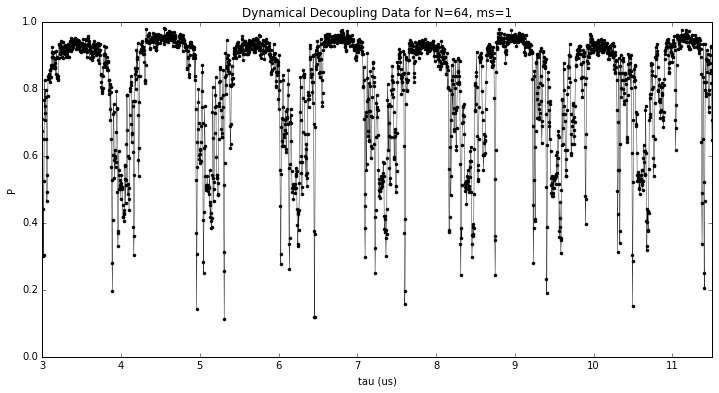

In [45]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,11.5], ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
ax.plot(tau * 1e6, .5 * (1 + data), '.-k', lw=0.4, label = 'data')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Dynamical Decoupling Data for N=64, ms=1")
plt.savefig(figures_path + "Dynamical_Decoupling/dynamical_decoupling_data_N" + str(N) + "_ms" + str(ms))
plt.show()

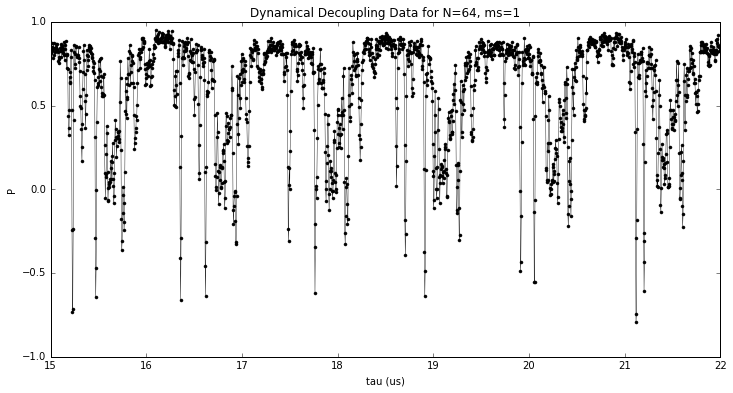

In [39]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [15, 22], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('P')
ax.plot(tau[3220:] * 1e6, data[3220:], '.-k', lw=0.4, label = 'data')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Dynamical Decoupling Data for N=64, ms=1")
#plt.savefig(figures_path + "Dynamical_Decoupling/dynamical_decoupling_data_N" + str(N) + "_ms" + str(ms))
plt.show()

In [65]:
#A_rand, B_rand, r, costheta, sintheta = NV_generator.generate_spins(450, coupling_bound = 130 * 2 * np.pi * 1e3)

In [69]:
#np.savez("diamond_example.npz", A_rand = A_rand, B_rand = B_rand, r = r, costheta = costheta, sintheta = sintheta)

In [46]:
diamond = np.load("diamond_example.npz")
A_rand, B_rand, r, costheta, sintheta = diamond["A_rand"], diamond["B_rand"], diamond["r"], diamond["costheta"], diamond["sintheta"]

In [47]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
omega_larmor = -1 * ms * gam_c * B_field
N = 64
tau = analysis.choose_tau_params(N)
def data_func(N, tau, noise_level = .02): #put the noise at .02
    data = analysis.calc_M(A_rand, B_rand, N, omega_larmor, tau)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise
print len(A_rand)

462


In [48]:
M = data_func(N, tau, 0)

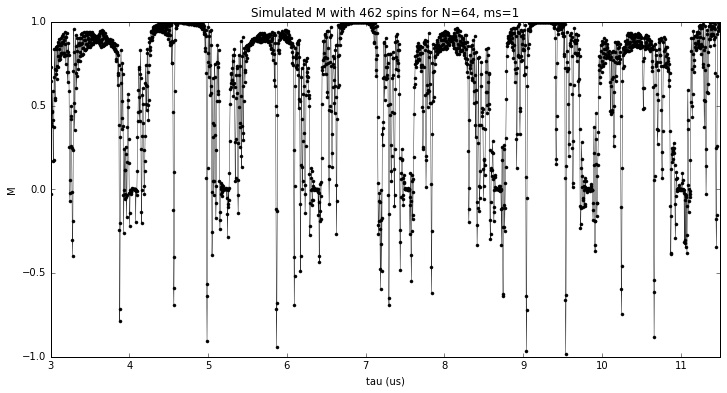

In [49]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,11.5], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau * 1e6, M, '.-k', lw=0.4, label = 'M')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with " + str(len(A_rand)) + " spins for N=" + str(N) +", ms=" + str(ms))
plt.savefig(figures_path + "Dynamical_Decoupling/dynamical_decoupling_M_simulation_N"+str(N)+"_ms"+str(ms))
plt.show()

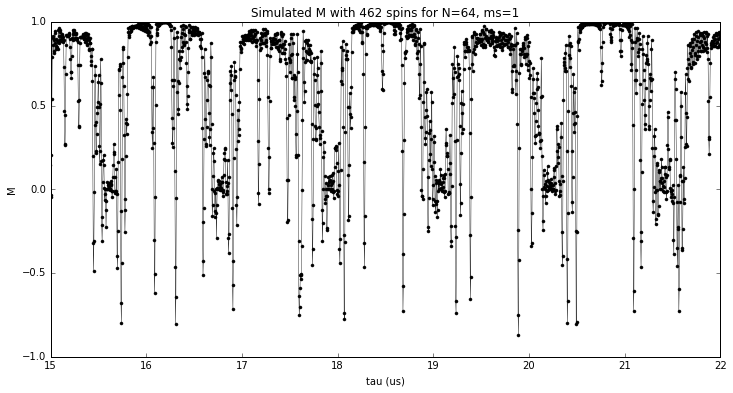

In [50]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [15,22], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau[3220:] * 1e6, M[3220:], '.-k', lw=0.4, label = 'M')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with " + str(len(A_rand)) + " spins for N=" + str(N) +", ms=" + str(ms))
#plt.savefig(figures_path + "dynamical_decoupling_M_simulation_N"+str(N)+"_ms"+str(ms))
plt.show()

In [28]:
As, Bs = analysis.analyze_diamond(data_func, N, omega_larmor)

In [31]:
num_correct = 0
spins = set(zip(A_rand, np.abs(B_rand)))
for A, B in zip(As, np.abs(Bs)):
    for spin in spins:
        if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
            num_correct = num_correct + 1
            spins.remove(spin)
            break
num_incorrect = len(As) - num_correct
print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

correct:  8 incorrect:  7


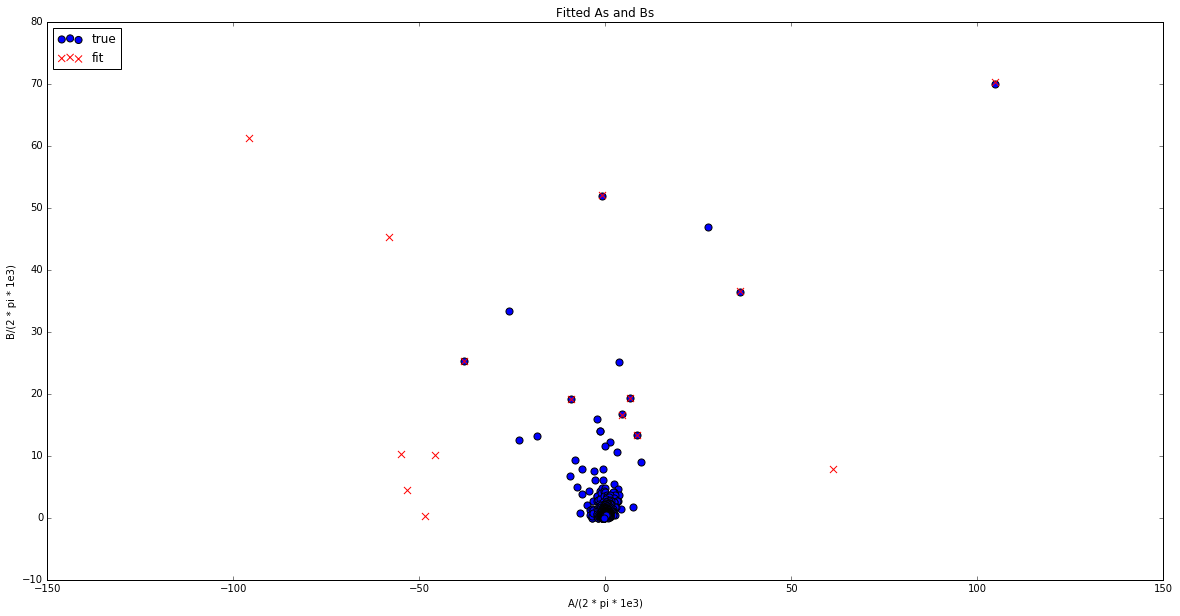

In [32]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(A_rand/analysis.mag, np.abs(B_rand)/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(As/analysis.mag, np.abs(Bs)/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()

In [52]:
strong_ind = 1
M_strong = analysis.calc_M_single(A_rand[strong_ind], B_rand[strong_ind], N, omega_larmor, tau)
print A_rand[strong_ind]/(2 * np.pi * 1e3), B_rand[strong_ind]/(2 * np.pi * 1e3), r[strong_ind],omega_larmor/(2 * np.pi * 1e3)

-37.8840775923 25.3081798574 7.72927672878e-10 -432.008847152


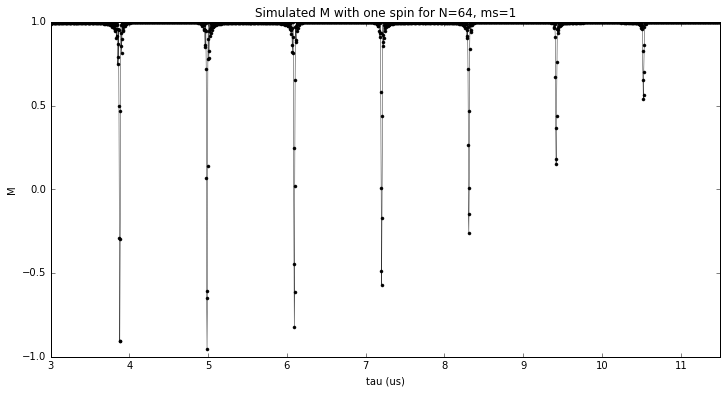

In [54]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,11.5], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau * 1e6, M_strong, '.-k', lw=0.4, label = 'M')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with one spin for N=" + str(N) +", ms=" + str(ms))
plt.savefig(figures_path + "Dynamical_Decoupling/dynamical_decoupling_simulation_1spin_strong_N" + str(N) + "_ms" + str(ms))
plt.show()

In [55]:
weak_ind = 70
M_weak = analysis.calc_M_single(A_rand[weak_ind], B_rand[weak_ind], N, omega_larmor, tau)
print A_rand[weak_ind]/(2 * np.pi * 1e3), B_rand[weak_ind]/(2 * np.pi * 1e3), r[weak_ind],omega_larmor/(2 * np.pi * 1e3)

3.19497569287 -2.67321422777 2.06628688715e-09 -432.008847152


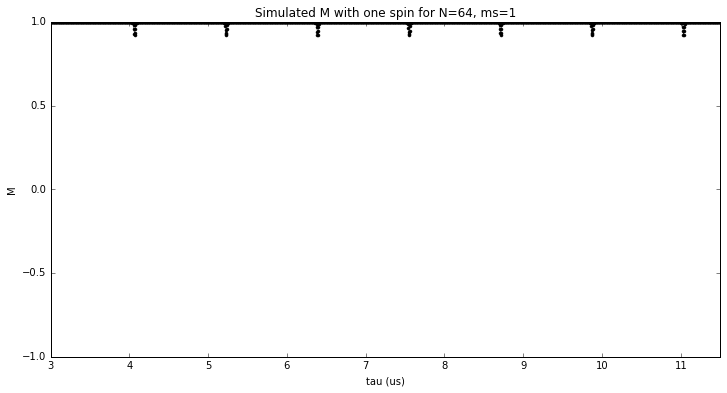

In [56]:
%matplotlib inline
fig,ax = analysis.initialize_data_plot(figsize = (12,6), xlims = [3,11.5], ylims = [-1,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau * 1e6, M_weak, '.-k', lw=0.4, label = 'M')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with one spin for N=" + str(N) +", ms=" + str(ms))
plt.savefig(figures_path + "Dynamical_Decoupling/dynamical_decoupling_simulation_1spin_weak_N" + str(N) + "_ms" + str(ms))
plt.show()

In [137]:
def M_terms(A,B,N,omega_larmor,tau):
    tau = np.array(tau)
    omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
    mx = B/omega_tilde
    mz = (A+omega_larmor)/omega_tilde
    alpha = omega_tilde * tau
    beta = omega_larmor * tau
    cos_phi = np.cos(alpha) * np.cos(beta)- mz * np.sin(alpha) * np.sin(beta)
    vec_num = (mx ** 2) * (1-np.cos(alpha)) * (1-np.cos(beta))
    vec_denom = 1.0 + cos_phi
    for i in np.where(vec_denom == 0.0)[0]:
        vec_denom[i] = .0001
    vec_term = vec_num/vec_denom
    angle_term = np.sin(N * np.arccos(cos_phi) / 2.0) ** 2
    return vec_term, angle_term

x_weak, angle_weak = M_terms(A_rand[weak_ind], B_rand[weak_ind], 1, omega_larmor, tau)

<IPython.core.display.Javascript object>


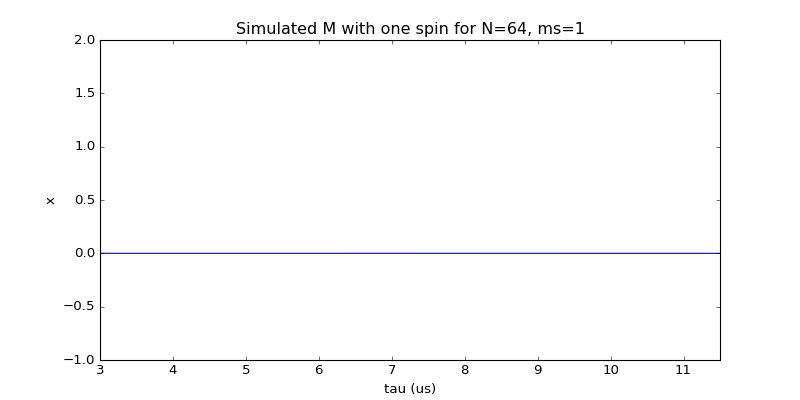

In [139]:
%matplotlib notebook
fig,ax = analysis.initialize_data_plot(xlims = [3,11.5], ylims = [-1,2])
ax.set_xlabel('tau (us)')
ax.set_ylabel('x')
#ax.plot(tau * 1e6, x_weak, '.-k', lw=0.4, label = 'x')
ax.plot(tau * 1e6, x_weak * angle_weak, label = 'angle')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with one spin for N=" + str(N) +", ms=" + str(ms))
#plt.savefig(figures_path + "dynamical_decoupling_simulation_1spin_weak_N" + str(N) + "_ms" + str(ms))
plt.show()

In [130]:
def res_tau(A, B, omega_larmor, k):
    omega_tilde = np.sqrt((A + omega_larmor) ** 2 + B ** 2)
    return (2 * k + 1) * np.pi/(omega_tilde + omega_larmor)
t = res_tau(A_rand[weak_ind], B_rand[weak_ind], omega_larmor, 3)
M_weak_N = analysis.calc_M_single(A_rand[weak_ind], B_rand[weak_ind], np.arange(0,128,2), omega_larmor, t)

<IPython.core.display.Javascript object>


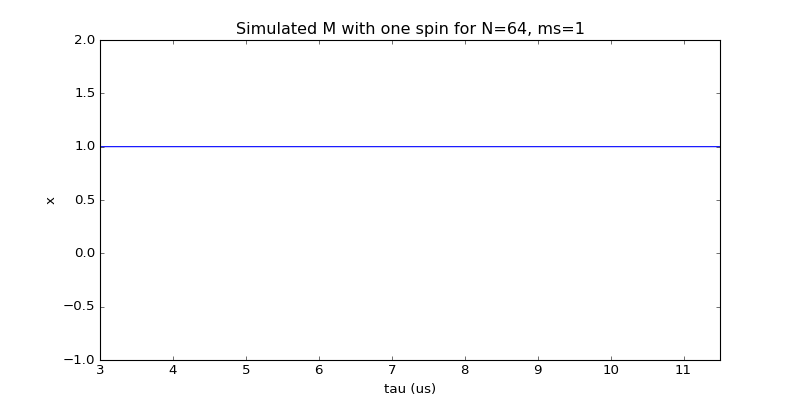

In [131]:
%matplotlib notebook
fig,ax = analysis.initialize_data_plot(xlims = [3,11.5], ylims = [-1,2])
ax.set_xlabel('tau (us)')
ax.set_ylabel('x')
#ax.plot(tau * 1e6, x_weak, '.-k', lw=0.4, label = 'x')
ax.plot(np.arange(0,128,2), M_weak_N, label = 'angle')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with one spin for N=" + str(N) +", ms=" + str(ms))
#plt.savefig(figures_path + "dynamical_decoupling_simulation_1spin_weak_N" + str(N) + "_ms" + str(ms))
plt.show()

### Everything below here is trash

In [120]:
ind = 45
def data_func_1(N, tau, noise_level = .02): #put the noise at .02
    data = analysis.calc_M_single(A_rand[ind], B_rand[ind], N, omega_larmor, tau)
    noise = np.random.randn(len(data)) * noise_level
    return data + noise
M_1 = data_func_1(N, tau, 0)
print A_rand[ind]/(2 * np.pi * 1e3), B_rand[ind]/(2 * np.pi * 1e3), omega_larmor/(2 * np.pi * 1e3)

0.46773412624 -3.80131719352 -432.008847152


<IPython.core.display.Javascript object>


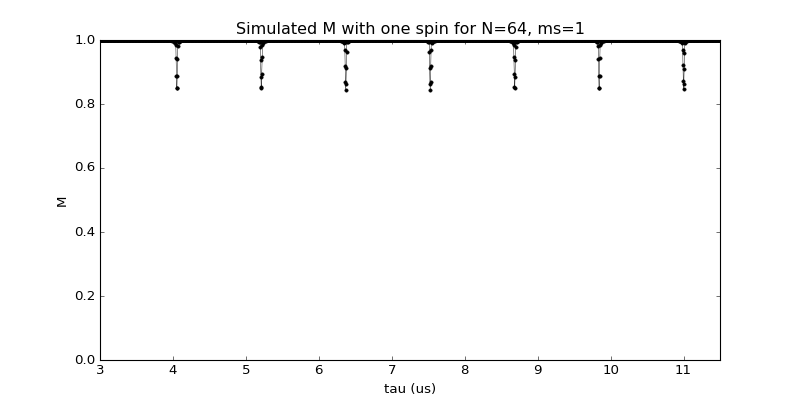

In [121]:
%matplotlib notebook
fig,ax = analysis.initialize_data_plot(xlims = [3,11.5], ylims = [0,1])
ax.set_xlabel('tau (us)')
ax.set_ylabel('M')
ax.plot(tau * 1e6, M_1, '.-k', lw=0.4, label = 'M')
#plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
plt.title("Simulated M with one spin for N=64, ms=1")
plt.savefig("dynamical_decoupling_simulation_1spin_weak_N64_ms1")
plt.show()

In [73]:
A_rand[1]/(2 * np.pi * 1e3), B_rand[1]/(2 * np.pi * 1e3)

(45.768554429636573, -64.726510404603204)